# ADV data starter code

**Note**: This code uses the SciPy package. For example, using Conda:

``` console
$ conda install scipy
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr

Read in the ADV data using Xarray.

In [2]:
ADV_FILE_PATH = 'your path here'  # e.g. './data/TTT_ADV_Feb2011_phasedespiked.nc'
adv_data = xr.open_dataset(ADV_FILE_PATH)
adv_data.attrs['sampling_frequency_hz'] = 32

adv_data

<xarray.Dataset>
Dimensions:  (t: 12058624)
Coordinates:
  * t        (t) float64 0.03125 0.0625 0.09375 ... 3.768e+05 3.768e+05
Data variables:
    u        (t) float64 ...
    v        (t) float64 ...
    w        (t) float64 ...
Attributes:
    sampling_frequency_hz:  32

Plot the raw velocity data versus time.


Text(0.5, 0, 'hour of data collection (hr)')

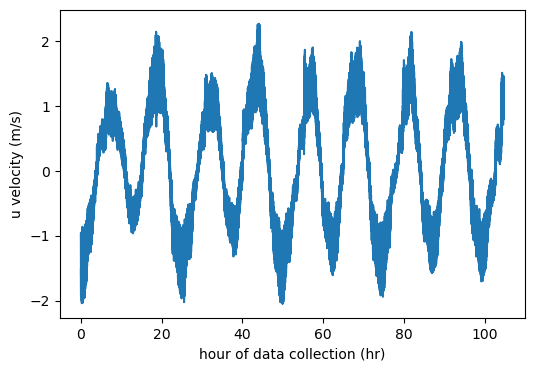

In [3]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(adv_data['t'] / 3600, adv_data['u'])
ax.set_ylabel('u velocity (m/s)')
ax.set_xlabel('hour of data collection (hr)')

Window the data.  Here I'll demonstrate using the u-component and the same code as in the ADCP notebook which was adapted from:
https://stackoverflow.com/questions/41815361/average-every-x-numbers-in-numpy-array.

In [4]:
def create_windows(arr, n):
    """ Bin an array into padded windows of size `n`. """
    # pad array to a multiple of `n` using nan
    xp = np.r_[arr, np.nan + np.zeros((-len(arr) % n,))]
    # reshape into `n` rows (each window) and average across windows
    return xp.reshape(-1, n)

The ensemble window length is set to the length used in the paper (feel free to adjust).  In the code below, Here `'t_window'` is time (in seconds) within each window and `'t_ensemble_mean'` is the mean observation time that each window represents.

In [5]:
window_length = 300  # seconds (TODO: play with this)
n = adv_data.attrs['sampling_frequency_hz'] * window_length  # number of samples in each window

# Create the coordinates for the ensembles.
time_windows = create_windows(adv_data['t'].values, n)
time_ensemble_mean = time_windows.mean(axis=-1)
time_window = np.arange(1, n + 1, 1) * adv_data.attrs['sampling_frequency_hz']**(-1)

# Assign coordinates to the Dataset.
adv_data['t_ensemble_mean'] = time_ensemble_mean
adv_data['t_window'] =  time_window

# Window u-component and assign to the Dataset. This line assigns a variable by
# specifying the dimensions and then the data as a Tuple.
# See https://xarray.pydata.org/en/v2024.02.0/generated/xarray.Dataset.html.
adv_data['u_windows'] = (['t_ensemble_mean', 't_window'],
                          create_windows(adv_data['u'].values, n))

adv_data

<xarray.Dataset>
Dimensions:          (t: 12058624, t_ensemble_mean: 1257, t_window: 9600)
Coordinates:
  * t                (t) float64 0.03125 0.0625 0.09375 ... 3.768e+05 3.768e+05
  * t_ensemble_mean  (t_ensemble_mean) float64 150.0 450.0 ... 3.767e+05 nan
  * t_window         (t_window) float64 0.03125 0.0625 0.09375 ... 300.0 300.0
Data variables:
    u                (t) float64 -1.518 -1.52 -1.485 ... 1.007 0.994 1.073
    v                (t) float64 ...
    w                (t) float64 ...
    u_windows        (t_ensemble_mean, t_window) float64 -1.518 -1.52 ... nan
Attributes:
    sampling_frequency_hz:  32

Calculate the u-component ensemble average by taking the mean along the `'t_window'` dimension.

In [6]:
adv_data['u_ensemble_mean'] = adv_data['u_windows'].mean(dim='t_window')

Plot the ensemble-averaged data and zoom into the first hour.

(-3.0, 0.0)

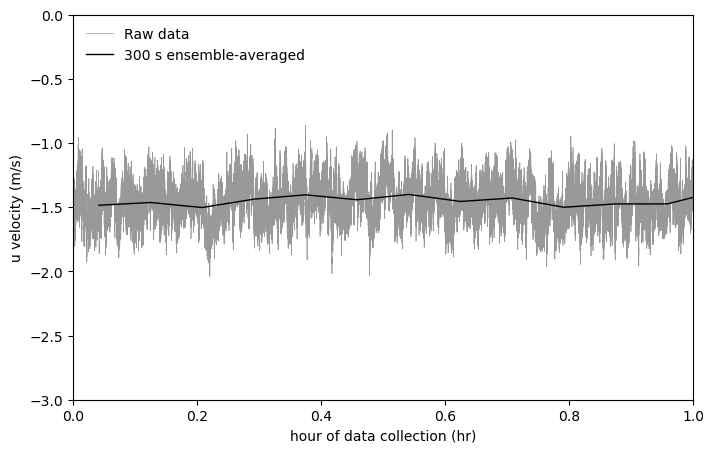

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(
    adv_data['t'] / 3600,
    adv_data['u'],
    color='k',
    label='Raw data',
    alpha=0.4,
    linewidth=0.5
)
ax.plot(
    adv_data['t_ensemble_mean'] / 3600,
    adv_data['u_ensemble_mean'],
    color='k',
    label=f'{window_length} s ensemble-averaged',
    linewidth=1
)
ax.set_ylabel('u velocity (m/s)')
ax.set_xlabel('hour of data collection (hr)')
ax.legend(frameon=False, loc='upper left')
ax.set_xlim([0, 1])
ax.set_ylim([-3, 0])

Create power density spectra. **DO NOT** use the default values for the keyword arguments in `pwelch_kwargs`. At a minimum, change `nperseg`. See https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html for descriptions and Thomson et al. 2012a (linked in the HW) for inspiration.

In [8]:
#TODO: play with these:
pwelch_kwargs = dict(
    window='hann',
    nperseg=None,
    noverlap=None,
    nfft=None,
)

frequency, u_spectral_density = scipy.signal.welch(
    x=adv_data['u_windows'],
    fs=adv_data.attrs['sampling_frequency_hz'],
    scaling='density',  # you can leave the following arguments alone
    return_onesided=True,
    axis=-1,
    **pwelch_kwargs,
)

# Add the spectra to the Dataset.
adv_data['f'] = frequency
adv_data['u_spectral_density'] = (['t_ensemble_mean', 'f'],
                                  u_spectral_density)

adv_data

<xarray.Dataset>
Dimensions:             (t: 12058624, t_ensemble_mean: 1257, t_window: 9600,
                         f: 129)
Coordinates:
  * t                   (t) float64 0.03125 0.0625 ... 3.768e+05 3.768e+05
  * t_ensemble_mean     (t_ensemble_mean) float64 150.0 450.0 ... 3.767e+05 nan
  * t_window            (t_window) float64 0.03125 0.0625 ... 300.0 300.0
  * f                   (f) float64 0.0 0.125 0.25 0.375 ... 15.75 15.88 16.0
Data variables:
    u                   (t) float64 -1.518 -1.52 -1.485 ... 1.007 0.994 1.073
    v                   (t) float64 ...
    w                   (t) float64 ...
    u_windows           (t_ensemble_mean, t_window) float64 -1.518 -1.52 ... nan
    u_ensemble_mean     (t_ensemble_mean) float64 -1.485 -1.463 ... 1.1 1.093
    u_spectral_density  (t_ensemble_mean, f) float64 0.004227 0.0191 ... nan nan
Attributes:
    sampling_frequency_hz:  32

Plot the first spectra as an example (but know it is probably not a good spectrum, since the pwelch inputs need to be adjusted).

Text(0.5, 0, 'frequency (Hz)')

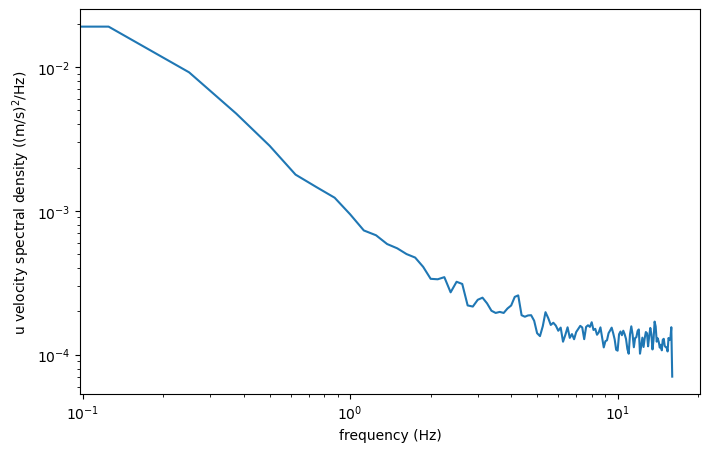

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(
    adv_data['f'],
    adv_data['u_spectral_density'][0],
)
ax.set_xscale('log')  # set the log-log scale
ax.set_yscale('log')
ax.set_ylabel('u velocity spectral density ((m/s)$^2$/Hz)')
ax.set_xlabel('frequency (Hz)')